In [1]:
import pickle
import sklearn
import seaborn
import pandas
import numpy

# Graphs, visualizations
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
# For Image Data Augmentation

import sklearn.model_selection
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import layers
from keras.optimizers import Adam

In [2]:
''' For GPU optimization (if needed)
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
'''

' For GPU optimization (if needed)\nfrom tensorflow.compat.v1.keras.backend import set_session\n\nconfig = tf.compat.v1.ConfigProto()\nconfig.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU\nconfig.log_device_placement = True  # to log device placement (on which device the operation ran)\nsess = tf.compat.v1.Session(config=config)\nset_session(sess)\n'

In [3]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()

In [4]:
#Train-validation-test split

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.2,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.25,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(166514, 50, 50, 3) (166514,) 0.7144444310988866
(55505, 50, 50, 3) (55505,) 0.7182415998558689
(55505, 50, 50, 3) (55505,) 0.7189802720475633


(50, 50, 3)

In [5]:
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    seaborn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pandas.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pandas.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, colors, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    
    i = 0
    colors=colors
    
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('train accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    i = 0
    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    
def prec_rec_df(models):
    columns = ['model' ,'precision (cancer positive)', 'recall (cancer positive)']
    df = pandas.DataFrame(columns = columns)
    for model in models:
        matrix = sklearn.metrics.confusion_matrix(y_test, [1 * (x[0]>=0.5) for x in model.predict(x_test)])
        precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
        recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])


        df = df.append(pandas.DataFrame([[model.name,
                                      precision,
                                      recall]], 
                            columns = columns))
    df = df.set_index('model')

    df = df.style.format({
        'precision (cancer positive)': '{:,.2%}'.format,
        'recall (cancer positive)': '{:,.2%}'.format})

    return df
    

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=4,
                       min_lr=1e-4,
                       verbose=2)

In [6]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

del X_data
del y_data

epochs = 100
batch_size = 2048
histories = []

Weight for class 0: 1.40
Weight for class 1: 3.52


<h1>Simple Convolutional Network</h1>

<p> From the dense network notebook we learned, that the learning rate of 0.001 was a good learning rate for the adam optimizer to take for the dense network. The simple convolutional network contain only 1 convolutional layer and a simple dense layer. In the there is only a convolutional layer a a maxpool layer. The activation function for the convolutional layer is ReLu.</p>

In [7]:
name="1-Conv-128-balanced"
model0 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model0.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(
    model0.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))

Epoch 1/100
82/82 [==============================] - 7s 82ms/step - loss: 84.7798 - accuracy: 0.6197 - val_loss: 0.5989 - val_accuracy: 0.7248
Epoch 2/100
82/82 [==============================] - 6s 79ms/step - loss: 1.2406 - accuracy: 0.7148 - val_loss: 0.5451 - val_accuracy: 0.7646
Epoch 3/100
82/82 [==============================] - 6s 79ms/step - loss: 1.0340 - accuracy: 0.7754 - val_loss: 0.5950 - val_accuracy: 0.7145
Epoch 4/100
82/82 [==============================] - 7s 80ms/step - loss: 0.9709 - accuracy: 0.7844 - val_loss: 0.4554 - val_accuracy: 0.8078
Epoch 5/100
82/82 [==============================] - 6s 79ms/step - loss: 0.9399 - accuracy: 0.7931 - val_loss: 0.5309 - val_accuracy: 0.7671
Epoch 6/100
82/82 [==============================] - 6s 78ms/step - loss: 0.9289 - accuracy: 0.7972 - val_loss: 0.4419 - val_accuracy: 0.8103
Epoch 7/100
82/82 [==============================] - 6s 78ms/step - loss: 0.9238 - accuracy: 0.7944 - val_loss: 0.4341 - val_accuracy: 0.8172
Epoch

<p>The second simple CNN is build similar to the first one. One difference is that there will the a batch normalization after the convolutional layer.</p>

In [8]:
name="1-Conv-128-norm-balanced"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(
    model1.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))

Epoch 1/100
82/82 [==============================] - 12s 150ms/step - loss: 1.0088 - accuracy: 0.8001 - val_loss: 8.1194 - val_accuracy: 0.7189
Epoch 2/100
82/82 [==============================] - 13s 160ms/step - loss: 0.8073 - accuracy: 0.8185 - val_loss: 1.1942 - val_accuracy: 0.7607
Epoch 3/100
82/82 [==============================] - 12s 150ms/step - loss: 0.7529 - accuracy: 0.8343 - val_loss: 0.7289 - val_accuracy: 0.7875
Epoch 4/100
82/82 [==============================] - 12s 149ms/step - loss: 0.7187 - accuracy: 0.8449 - val_loss: 0.3671 - val_accuracy: 0.8446
Epoch 5/100
82/82 [==============================] - 12s 149ms/step - loss: 0.6964 - accuracy: 0.8496 - val_loss: 1.2562 - val_accuracy: 0.7194
Epoch 6/100
82/82 [==============================] - 12s 149ms/step - loss: 0.6658 - accuracy: 0.8577 - val_loss: 0.5382 - val_accuracy: 0.7416
Epoch 7/100
82/82 [==============================] - 12s 148ms/step - loss: 0.6378 - accuracy: 0.8645 - val_loss: 0.7148 - val_accuracy:

In [9]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-Conv-128-balanced,0.89,80.25%,0.43,82.00%
1-Conv-128-norm-balanced,0.39,92.29%,0.37,84.86%


In [10]:
models = [model0, model1]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-Conv-128-balanced,67.99%,66.63%
1-Conv-128-norm-balanced,75.64%,67.18%


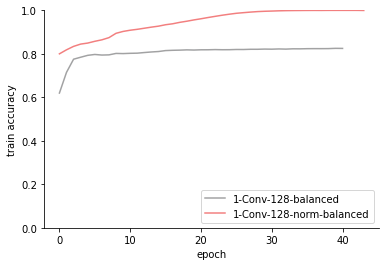

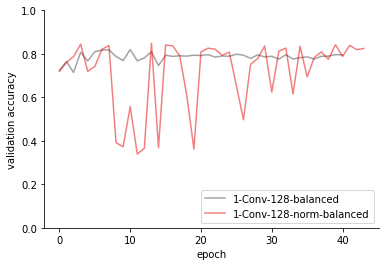

In [11]:
plot_accuracies(histories,colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'],
                alpha=.5, lower_ylim=0, upper_ylim=1)

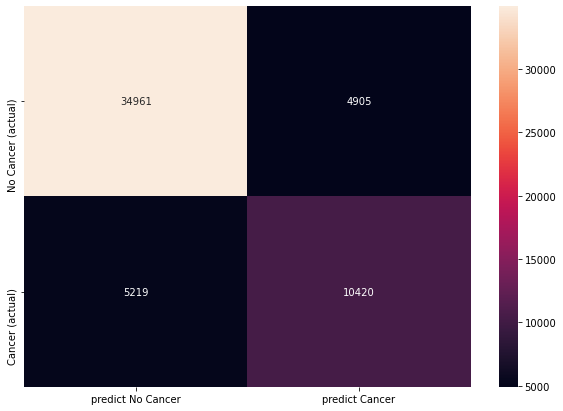

In [12]:
# plot confuction matrix
plt=conf_matrix(model0, x_test, y_test)
plt.show()

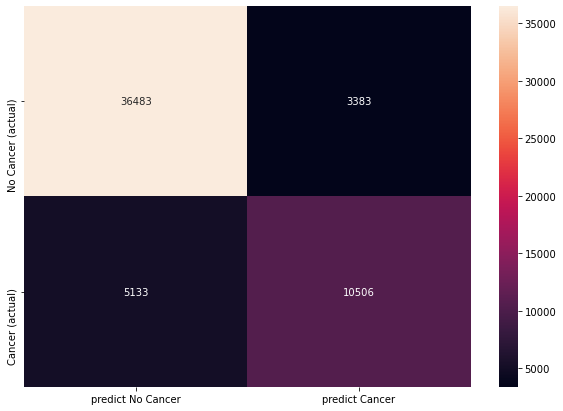

In [13]:
# plot confuction matrix
plt=conf_matrix(model1, x_test, y_test)
plt.show()

<h1> Advanced CNN </h1>

<p>This CNN is an advanced verson of the CNN. The first CNN contains 2 convolutional layers. Each layer gets batch normalized and before the flattening there is also a max pooling layer.</p>

In [14]:
epochs = 50
batch_size = 1024

In [15]:
name="2-Conv-128-norm-balanced"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(128, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(
    model2.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))

Epoch 1/50
163/163 [==============================] - 48s 292ms/step - loss: 0.8591 - accuracy: 0.8187 - val_loss: 5.4840 - val_accuracy: 0.7190
Epoch 2/50
163/163 [==============================] - 46s 285ms/step - loss: 0.7435 - accuracy: 0.8391 - val_loss: 2.2278 - val_accuracy: 0.7190
Epoch 3/50
163/163 [==============================] - 47s 287ms/step - loss: 0.7106 - accuracy: 0.8454 - val_loss: 2.6473 - val_accuracy: 0.7191
Epoch 4/50
163/163 [==============================] - 47s 288ms/step - loss: 0.6906 - accuracy: 0.8504 - val_loss: 0.4493 - val_accuracy: 0.8015
Epoch 5/50
163/163 [==============================] - 47s 287ms/step - loss: 0.6708 - accuracy: 0.8561 - val_loss: 0.5326 - val_accuracy: 0.7434
Epoch 6/50
163/163 [==============================] - 48s 294ms/step - loss: 0.6564 - accuracy: 0.8585 - val_loss: 0.7251 - val_accuracy: 0.7584
Epoch 7/50
163/163 [==============================] - 48s 294ms/step - loss: 0.6345 - accuracy: 0.8639 - val_loss: 0.5550 - val_ac

In [16]:
name="2-Conv-128-norm-dropout-balanced"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(128,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size = (5, 5), activation='relu'),
        layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Flatten(),
        keras.layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model3.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(
    model3.fit(
        x_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val,y_val), 
        callbacks=[lrr, es], 
        class_weight=class_weight))

Epoch 1/50
163/163 [==============================] - 55s 340ms/step - loss: 0.9417 - accuracy: 0.7999 - val_loss: 4.4981 - val_accuracy: 0.7190
Epoch 2/50
163/163 [==============================] - 55s 335ms/step - loss: 0.7725 - accuracy: 0.8339 - val_loss: 2.0761 - val_accuracy: 0.7190
Epoch 3/50
163/163 [==============================] - 52s 317ms/step - loss: 0.7476 - accuracy: 0.8396 - val_loss: 0.5909 - val_accuracy: 0.8139
Epoch 4/50
163/163 [==============================] - 50s 308ms/step - loss: 0.7270 - accuracy: 0.8450 - val_loss: 0.9043 - val_accuracy: 0.4994
Epoch 5/50
163/163 [==============================] - 51s 314ms/step - loss: 0.6980 - accuracy: 0.8518 - val_loss: 0.7259 - val_accuracy: 0.6364
Epoch 6/50
163/163 [==============================] - 50s 308ms/step - loss: 0.6858 - accuracy: 0.8543 - val_loss: 1.1795 - val_accuracy: 0.4578
Epoch 7/50
163/163 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.8585
Epoch 00007: ReduceLROnPlateau red

In [17]:
acc_df(histories[-2:])

,loss,accuracy,val_loss,val_accuracy
model size,,,,
2-Conv-128-norm-balanced,0.17,97.21%,0.41,85.75%
2-Conv-128-norm-dropout-balanced,0.75,83.96%,0.59,81.39%


In [18]:
models = [model2, model3]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
2-Conv-128-norm-balanced,73.72%,74.32%
2-Conv-128-norm-dropout-balanced,78.55%,45.81%


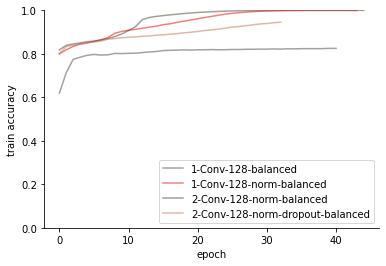

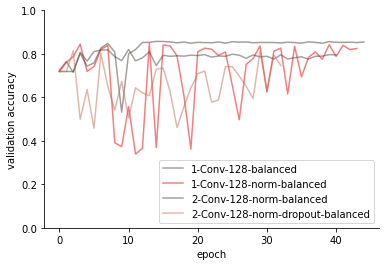

In [19]:
plot_accuracies(histories,colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'],
                alpha=.5, lower_ylim=0, upper_ylim=1)

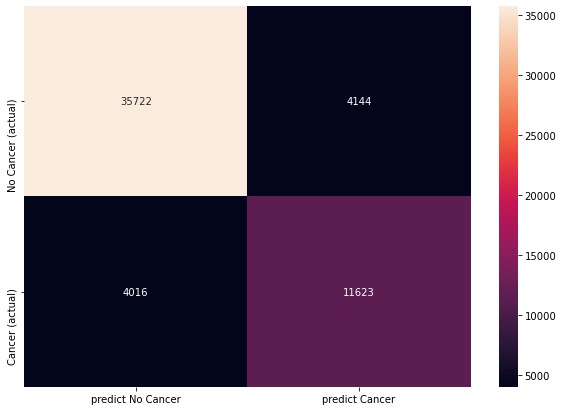

In [20]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

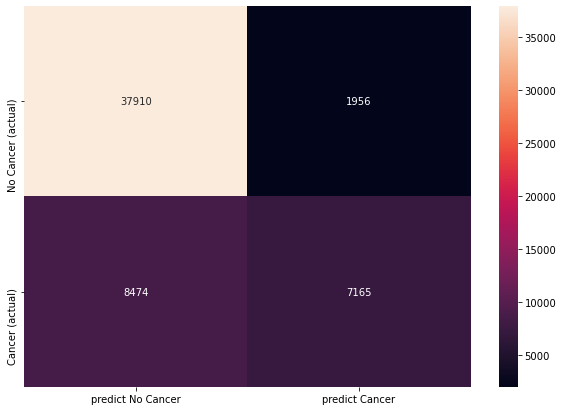

In [21]:
# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

<h1> Learnings </h1>

<p>Testtesttest </p>

<h1>Advanced CNN with optimized dense layer</h1>

In [22]:
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

In [23]:
batch_size = 512
epochs = 50

name="4-Conv-128-256-norm-dropout"
model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(256,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model5.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model5.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=[lrr, es],
                            validation_data=(x_val,y_val)))

Epoch 1/50
326/326 [==============================] - 107s 329ms/step - loss: 0.4099 - accuracy: 0.8312 - val_loss: 0.3664 - val_accuracy: 0.8440
Epoch 2/50
326/326 [==============================] - 104s 320ms/step - loss: 0.3283 - accuracy: 0.8616 - val_loss: 0.3373 - val_accuracy: 0.8566
Epoch 3/50
326/326 [==============================] - 104s 320ms/step - loss: 0.3107 - accuracy: 0.8690 - val_loss: 0.3192 - val_accuracy: 0.8615
Epoch 4/50
326/326 [==============================] - 104s 320ms/step - loss: 0.3016 - accuracy: 0.8724 - val_loss: 0.3048 - val_accuracy: 0.8675
Epoch 5/50
326/326 [==============================] - 104s 320ms/step - loss: 0.2933 - accuracy: 0.8758 - val_loss: 0.3147 - val_accuracy: 0.8615
Epoch 6/50
326/326 [==============================] - 104s 320ms/step - loss: 0.2852 - accuracy: 0.8795 - val_loss: 0.3287 - val_accuracy: 0.8656
Epoch 7/50
326/326 [==============================] - 104s 320ms/step - loss: 0.2809 - accuracy: 0.8812 - val_loss: 0.2987 -

In [24]:
name="4-Conv-128-256-norm-dropout-balanced"
model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(256,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    
    ],name=name
)

model5.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model5.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_val,y_val),
                            callbacks=[lrr, es],
                            class_weight=class_weight))

Epoch 1/50
326/326 [==============================] - 105s 323ms/step - loss: 0.8701 - accuracy: 0.8135 - val_loss: 0.3833 - val_accuracy: 0.8371
Epoch 2/50
326/326 [==============================] - 105s 322ms/step - loss: 0.7394 - accuracy: 0.8415 - val_loss: 0.3569 - val_accuracy: 0.8436
Epoch 3/50
326/326 [==============================] - 105s 322ms/step - loss: 0.7036 - accuracy: 0.8486 - val_loss: 0.3276 - val_accuracy: 0.8589
Epoch 4/50
326/326 [==============================] - 105s 322ms/step - loss: 0.6793 - accuracy: 0.8534 - val_loss: 0.3441 - val_accuracy: 0.8423
Epoch 5/50
326/326 [==============================] - 106s 324ms/step - loss: 0.6608 - accuracy: 0.8573 - val_loss: 0.3540 - val_accuracy: 0.8451
Epoch 6/50
326/326 [==============================] - 106s 324ms/step - loss: 0.6487 - accuracy: 0.8595 - val_loss: 0.3780 - val_accuracy: 0.8397
Epoch 7/50
326/326 [==============================] - 105s 322ms/step - loss: 0.6318 - accuracy: 0.8621 - val_loss: 0.3260 -

In [25]:
acc_df(histories[-2:])

,loss,accuracy,val_loss,val_accuracy
model size,,,,
4-Conv-128-256-norm-dropout,0.27,88.70%,0.28,88.32%
4-Conv-128-256-norm-dropout-balanced,0.63,86.21%,0.33,86.23%


In [26]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-Conv-128-balanced,0.89,80.25%,0.43,82.00%
1-Conv-128-norm-balanced,0.39,92.29%,0.37,84.86%
2-Conv-128-norm-balanced,0.17,97.21%,0.41,85.75%
2-Conv-128-norm-dropout-balanced,0.75,83.96%,0.59,81.39%
4-Conv-128-256-norm-dropout,0.27,88.70%,0.28,88.32%
4-Conv-128-256-norm-dropout-balanced,0.63,86.21%,0.33,86.23%


In [29]:
models = [model5]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
4-Conv-128-256-norm-dropout-balanced,71.63%,84.73%


In [28]:
models = [model0, model1, model2, model3, model5]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-Conv-128-balanced,67.99%,66.63%
1-Conv-128-norm-balanced,75.64%,67.18%
2-Conv-128-norm-balanced,73.72%,74.32%
2-Conv-128-norm-dropout-balanced,78.55%,45.81%
4-Conv-128-256-norm-dropout-balanced,71.63%,84.73%


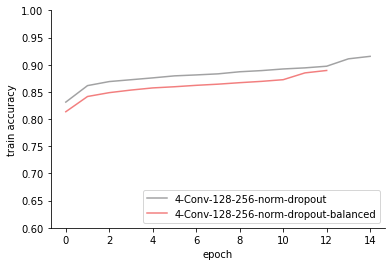

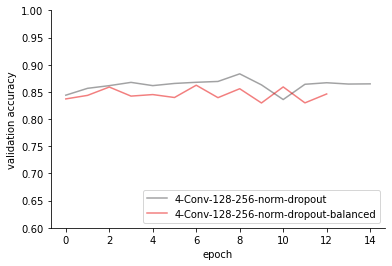

In [32]:
plot_accuracies(histories[-2:],colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'],
                alpha=.5, lower_ylim=0.6, upper_ylim=1)

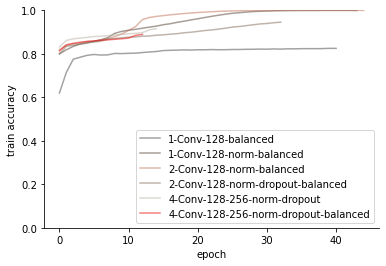

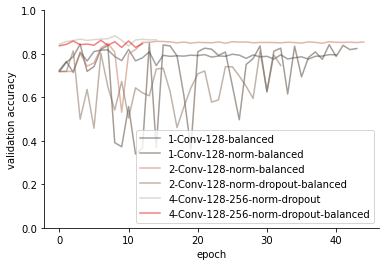

In [34]:
plot_accuracies(histories,colors=['#464749','#4d3c2f', '#c07156', '#806b59', '#b9b2a3', '#e60000'],
                alpha=.5, lower_ylim=0, upper_ylim=1)

In [ ]:
# plot confuction matrix
plt=conf_matrix(model4, x_test, y_test)
plt.show()

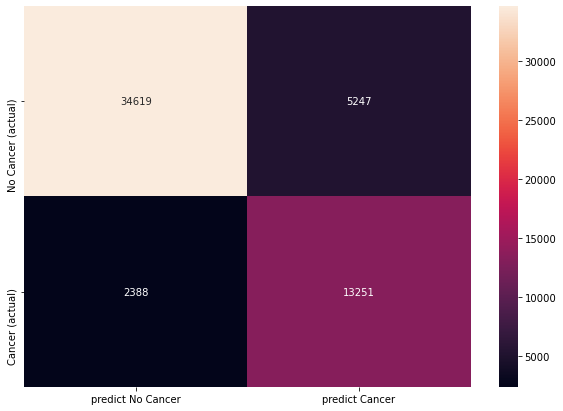

In [35]:
# plot confuction matrix
plt=conf_matrix(model5, x_test, y_test)
plt.show()